In [117]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.model_selection import train_test_split, cross_val_score, learning_curve
from sklearn.metrics import precision_score, recall_score, f1_score, confusion_matrix, roc_auc_score
from sklearn.metrics import classification_report, accuracy_score, roc_curve, auc, precision_recall_curve
from sklearn.model_selection import StratifiedKFold
from sklearn.preprocessing import PowerTransformer

from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.compose import ColumnTransformer

import category_encoders as ce

from scipy import stats
import statsmodels.stats.power as power

from imblearn.pipeline import Pipeline as Pipe
from itertools import combinations
from imblearn.combine import SMOTEENN

import xgboost
from xgboost import XGBClassifier
import optuna
from optuna.samplers import TPESampler

from BorutaShap import BorutaShap
import shap

Dataset: https://www.kaggle.com/datasets/sakshigoyal7/credit-card-customers

Full notebook
https://github.com/pankratozzi/ML_pet_projects/blob/main/classification/churn-prediction_v1.ipynb

In [2]:
data_root = 'BankChurners.csv'
TARGET_NAME = 'Attrition_Flag'

In [3]:
df = pd.read_csv(data_root)

In [11]:
def report(y_train, y_train_pred, y_test, y_test_pred, y_train_proba=None, y_test_proba=None):
    print('Train\n', classification_report(y_train, y_train_pred, digits=3))
    print('Test\n', classification_report(y_test, y_test_pred, digits=3))
    if y_train_proba is not None and y_test_proba is not None:
        roc_train, roc_test = roc_auc_score(y_train, y_train_proba), roc_auc_score(y_test, y_test_proba)
        print(f'Train ROC_AUC: {roc_train:.3f}, Test ROC_AUC: {roc_test:.3f}')

def reduce_memory(df):
    for col in df.columns:
        col_type = df[col].dtype
        if col_type != object and str(col_type)[:4] != 'uint' and str(col_type) != 'category':
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)
        elif str(col_type)[:4] != 'uint':
            df[col] = df[col].astype('category')
    return df

def statistic_output(*columns, df=df, cat=False, target=TARGET_NAME, alpha=0.05, sample_size=0):
    data = df.copy()
    data.drop_duplicates(inplace=True)
    if sample_size == 0:
        sample_size = int(0.05 * len(data))
    if not cat:
        columns = data.drop(target, axis=1).select_dtypes(exclude=['category', 'object']).columns
        for column in columns:
            df_sampled = data[[column, target]].sample(sample_size, random_state=1)
            factor_a = df_sampled.loc[df_sampled[target] == 0][column]   
            factor_b = df_sampled.loc[df_sampled[target] == 1][column]
            var_a, var_b = factor_a.var(), factor_b.var()   
            _, pvalue = stats.shapiro(df_sampled[column])
            if pvalue >= alpha:
                _, pvalue = stats.ttest_ind(factor_a, factor_b, equal_var=False)
                test = power.TTestIndPower()
                eff_size, deg_free = effect_size(factor_a, factor_b, cohen=False)
                pow = test.power(effect_size=eff_size, nobs1=len(factor_a), alpha=alpha, df=deg_free, 
                                 ratio=len(factor_b)/len(factor_a), alternative='two-sided')
            else:
                if len(factor_a) == 0 or len(factor_b) == 0:
                    continue
                _, pvalue = stats.mannwhitneyu(factor_a, factor_b)
                pow, eff_size = None, None
            if pvalue < alpha:
                result = f'with effect_size = {eff_size:.4f} and ttest power {pow*100:.2f}%' if pow is not None else ''
                print(f'Factor "{column}" has statistical impact on target (var_a: {var_a:.2f}, var_b: {var_b:.2f}). {result}')
            else:
                print(f'Factor "{column}" does not affect target.')
    else:
        for column in columns:
            print(column)
            categories = data[column].unique().tolist()
            for pair in combinations(categories, r=2):
                a, b = pair
                if a != b:
                    data_ = data.loc[data[column].isin(pair), ['CLIENTNUM', column, target]].sample(sample_size, random_state=1)
                    table = data_.pivot_table(values='CLIENTNUM', index=column, columns=target, aggfunc='count')
                    try:
                        _, pvalue, _, _ = stats.chi2_contingency(table, correction=False)
                    except ValueError:
                        continue
                    if pvalue >= alpha:
                        print(f'Categories {a} and {b} can be united. P-value: {pvalue:.6f}')
                    else:
                        print(f'Categories {a} and {b} have different frequencies with target.')
                        
def categorical_stats(df=df, target=TARGET_NAME, alpha=0.05, sample_size=500):
    data = df.copy().sample(sample_size)
    columns_to_analize = data.select_dtypes(include=['category', 'object']).columns
    weak_list = []
    for factor in columns_to_analize:
        if factor == target:
            continue
        print(f'{factor}')
        table = pd.crosstab(data[factor], data[TARGET_NAME])
        p_value = stats.chi2_contingency(table, correction=False)[1]
        if p_value < alpha:
            print(f'Feature {factor} has statistical impact on target. P-value: {p_value:.6f}')
        else:
            weak_list.append(factor)
    if len(weak_list) > 0:
        print(f'Statistically weak categorical features: ', *weak_list)

In [5]:
df.sample(8).transpose()

,6004,441,10009,7383,2879,6608,2276,4118
CLIENTNUM,767488908,814995933,719941533,713509908,720132258,788737083,715143333,709192233
Attrition_Flag,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Existing Customer,Attrited Customer
Customer_Age,41,58,32,48,49,34,45,50
Gender,M,F,F,F,M,F,F,F
Dependent_count,4,3,1,2,3,2,1,2
Education_Level,Unknown,Graduate,Graduate,Graduate,Post-Graduate,High School,High School,Unknown
Marital_Status,Married,Married,Married,Married,Single,Married,Divorced,Married
Income_Category,$80K - $120K,Less than $40K,Less than $40K,Unknown,$120K +,Less than $40K,Less than $40K,Unknown
Card_Category,Blue,Blue,Blue,Blue,Silver,Blue,Blue,Blue
Months_on_book,35,53,20,35,36,13,36,39


In [6]:
# remove two last columns as the author suggests
df = df.iloc[:, :-2]
print(f'Total columns {len(df.columns)}')

# check for duplicates
print(f'Number of duplicates: {df.duplicated().astype(int).sum()}')
df.drop_duplicates(inplace=True)

Total columns 21
Number of duplicates: 0


In [7]:
df.describe()

,CLIENTNUM,Customer_Age,Dependent_count,Months_on_book,Total_Relationship_Count,Months_Inactive_12_mon,Contacts_Count_12_mon,Credit_Limit,Total_Revolving_Bal,Avg_Open_To_Buy,Total_Amt_Chng_Q4_Q1,Total_Trans_Amt,Total_Trans_Ct,Total_Ct_Chng_Q4_Q1,Avg_Utilization_Ratio
count,1.012700e+04,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000,10127.000000
mean,7.391776e+08,46.325960,2.346203,35.928409,3.812580,2.341167,2.455317,8631.953698,1162.814061,7469.139637,0.759941,4404.086304,64.858695,0.712222,0.274894
std,3.690378e+07,8.016814,1.298908,7.986416,1.554408,1.010622,1.106225,9088.776650,814.987335,9090.685324,0.219207,3397.129254,23.472570,0.238086,0.275691
min,7.080821e+08,26.000000,0.000000,13.000000,1.000000,0.000000,0.000000,1438.300000,0.000000,3.000000,0.000000,510.000000,10.000000,0.000000,0.000000
25%,7.130368e+08,41.000000,1.000000,31.000000,3.000000,2.000000,2.000000,2555.000000,359.000000,1324.500000,0.631000,2155.500000,45.000000,0.582000,0.023000
50%,7.179264e+08,46.000000,2.000000,36.000000,4.000000,2.000000,2.000000,4549.000000,1276.000000,3474.000000,0.736000,3899.000000,67.000000,0.702000,0.176000
75%,7.731435e+08,52.000000,3.000000,40.000000,5.000000,3.000000,3.000000,11067.500000,1784.000000,9859.000000,0.859000,4741.000000,81.000000,0.818000,0.503000
max,8.283431e+08,73.000000,5.000000,56.000000,6.000000,6.000000,6.000000,34516.000000,2517.000000,34516.000000,3.397000,18484.000000,139.000000,3.714000,0.999000


In [8]:
df.describe(include=['object'])

,Attrition_Flag,Gender,Education_Level,Marital_Status,Income_Category,Card_Category
count,10127,10127,10127,10127,10127,10127
unique,2,2,7,4,6,4
top,Existing Customer,F,Graduate,Married,Less than $40K,Blue
freq,8500,5358,3128,4687,3561,9436


In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10127 entries, 0 to 10126
Data columns (total 21 columns):
 #   Column                    Non-Null Count  Dtype  
---  ------                    --------------  -----  
 0   CLIENTNUM                 10127 non-null  int64  
 1   Attrition_Flag            10127 non-null  object 
 2   Customer_Age              10127 non-null  int64  
 3   Gender                    10127 non-null  object 
 4   Dependent_count           10127 non-null  int64  
 5   Education_Level           10127 non-null  object 
 6   Marital_Status            10127 non-null  object 
 7   Income_Category           10127 non-null  object 
 8   Card_Category             10127 non-null  object 
 9   Months_on_book            10127 non-null  int64  
 10  Total_Relationship_Count  10127 non-null  int64  
 11  Months_Inactive_12_mon    10127 non-null  int64  
 12  Contacts_Count_12_mon     10127 non-null  int64  
 13  Credit_Limit              10127 non-null  float64
 14  Total_

In [10]:
df[TARGET_NAME].value_counts(normalize=True)

Existing Customer    0.83934
Attrited Customer    0.16066
Name: Attrition_Flag, dtype: float64

In [14]:
df = reduce_memory(df)

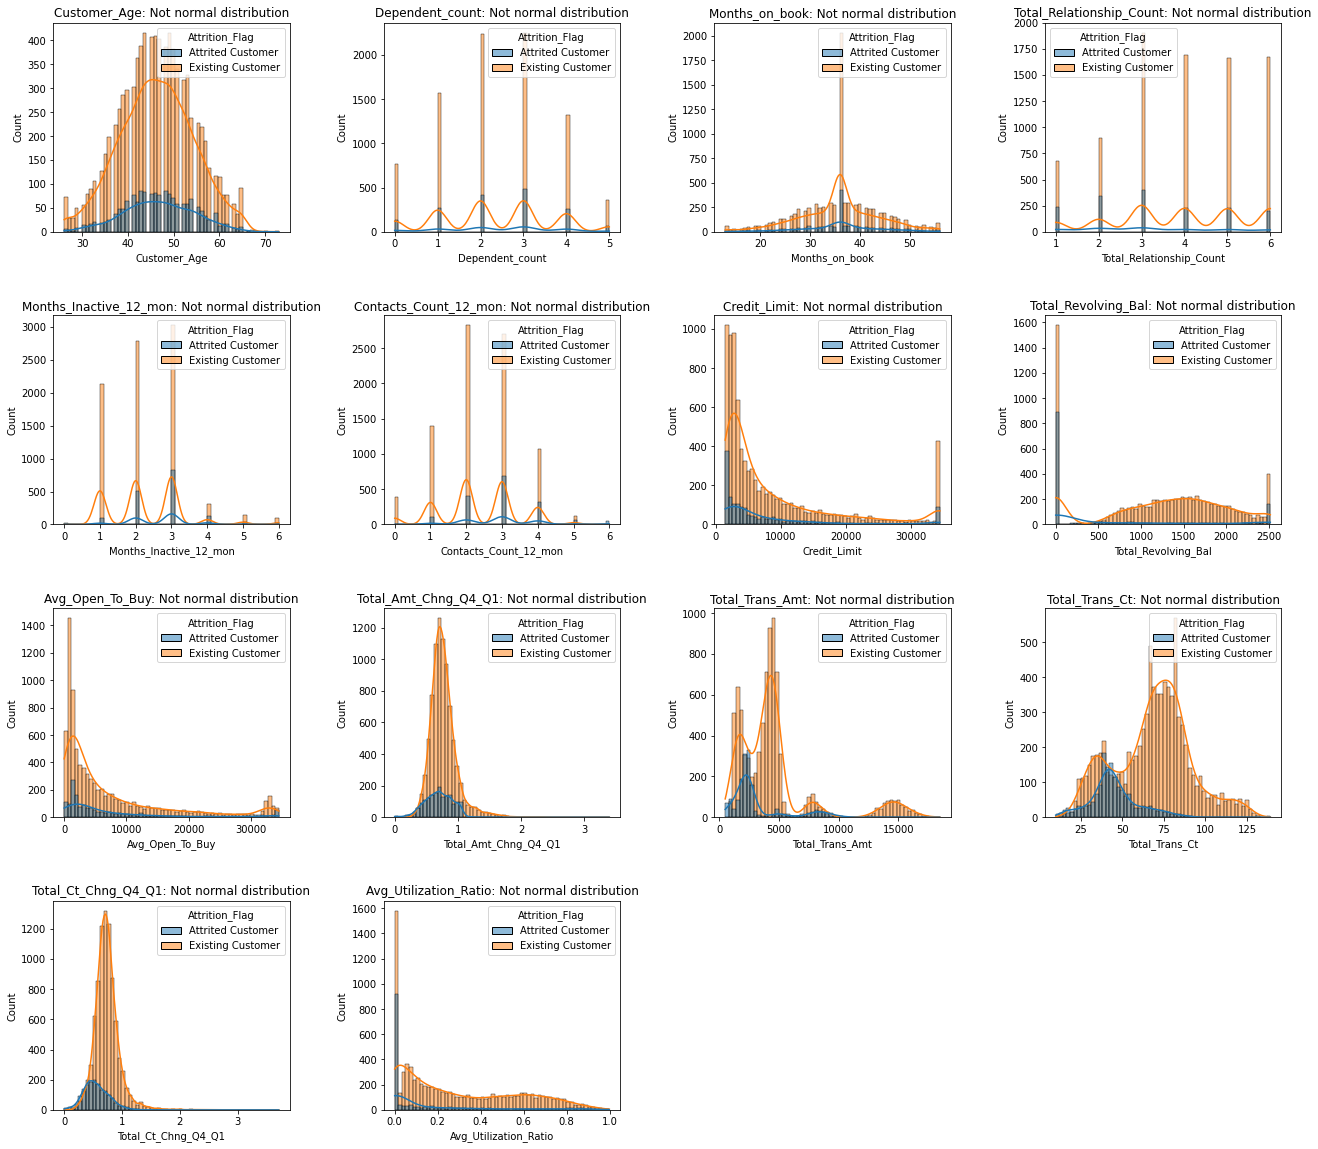

In [15]:
numerical_cols = df.select_dtypes(include=[np.int8, np.int16, np.float32]).columns.tolist()

plt.figure(figsize=(22, 20))
for idx, column in enumerate(numerical_cols):
    plt.subplot(4, 4, idx + 1)
    dist = 'Normal Distribution' if stats.shapiro(df[column].sample(1000))[1] > 0.05 else 'Not normal distribution'
    plt.title(f'{column}: {dist}')
    sns.histplot(data=df, x=column, hue=TARGET_NAME, bins=60, kde=True)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

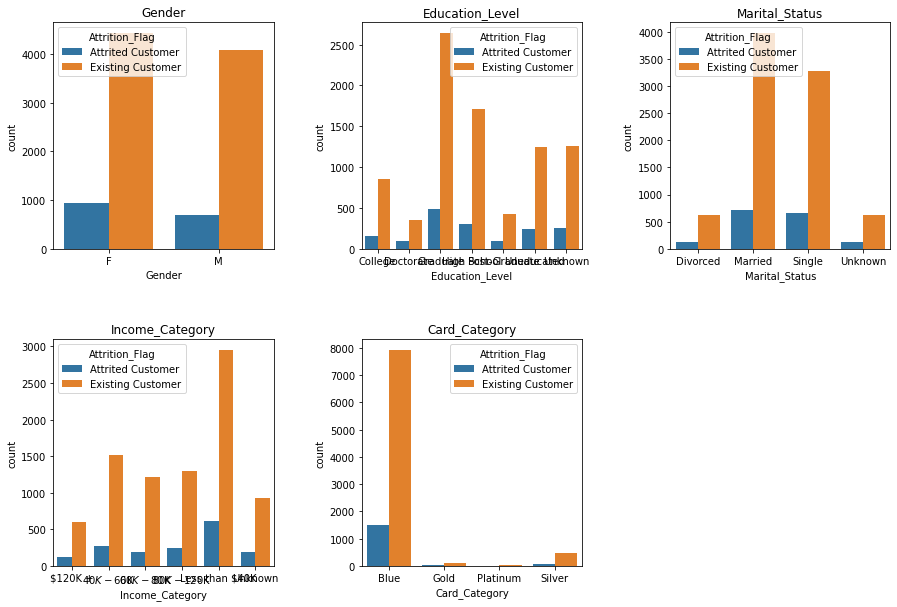

In [16]:
categorical_cols = df.drop(TARGET_NAME, axis=1).select_dtypes(include=['category']).columns

plt.figure(figsize=(15, 10))
for idx, column in enumerate(categorical_cols, 1):
    plt.subplot(2, 3, idx)
    plt.title(f'{column}')
    sns.countplot(x=column, hue=TARGET_NAME, data=df)
plt.subplots_adjust(hspace=0.4, wspace=0.4)
plt.show()

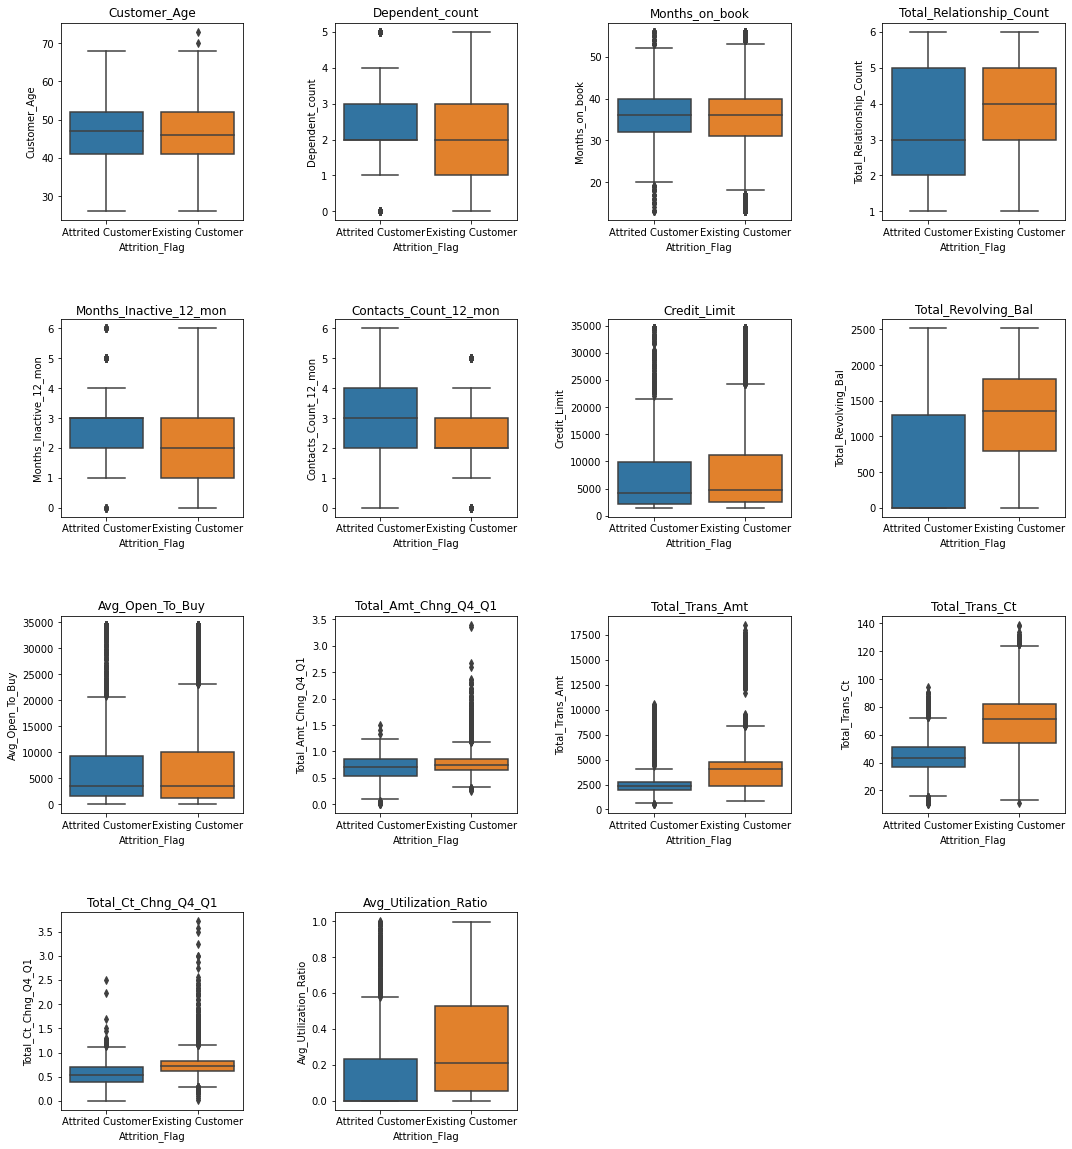

In [17]:
plt.figure(figsize=(18,20))
for idx, column in enumerate(numerical_cols, 1):
    plt.subplot(4, 4, idx)
    sns.boxplot(y=df[column], x=df[TARGET_NAME], data=df)
    plt.title(f'{column}')
plt.subplots_adjust(hspace=0.5, wspace=0.5)
plt.show()

In [18]:
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1})
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)

In [19]:
statistic_output(*numerical_cols, sample_size=500)

Factor "CLIENTNUM" has statistical impact on target (var_a: 1477484812435724.00, var_b: 1581338126040330.50). 
Factor "Customer_Age" does not affect target.
Factor "Dependent_count" does not affect target.
Factor "Months_on_book" does not affect target.
Factor "Total_Relationship_Count" has statistical impact on target (var_a: 2.28, var_b: 2.40). 
Factor "Months_Inactive_12_mon" has statistical impact on target (var_a: 1.06, var_b: 0.75). 
Factor "Contacts_Count_12_mon" has statistical impact on target (var_a: 1.21, var_b: 1.33). 
Factor "Credit_Limit" does not affect target.
Factor "Total_Revolving_Bal" has statistical impact on target (var_a: 592974.68, var_b: 647707.11). 
Factor "Avg_Open_To_Buy" does not affect target.
Factor "Total_Amt_Chng_Q4_Q1" has statistical impact on target (var_a: 0.03, var_b: 0.04). 
Factor "Total_Trans_Amt" has statistical impact on target (var_a: 12219797.20, var_b: 4473731.23). 
Factor "Total_Trans_Ct" has statistical impact on target (var_a: 529.85, va

In [20]:
statistic_output('Gender', cat=True, sample_size=500)

Gender
Categories M and F can be united. P-value: 0.423509


In [21]:
categorical_stats()

Gender
Education_Level
Marital_Status
Feature Marital_Status has statistical impact on target. P-value: 0.026567
Income_Category
Card_Category
Feature Card_Category has statistical impact on target. P-value: 0.026623
Statistically weak categorical features:  Gender Education_Level Income_Category


In [84]:
df = pd.read_csv(data_root) # read
df = df.iloc[:, :-2] # remove redundant columns
df.drop_duplicates(inplace=True) # drop duplicates
df = reduce_memory(df) # reduce memory
df[TARGET_NAME] = df[TARGET_NAME].map({'Existing Customer': 0, 'Attrited Customer': 1}) # map target
df[TARGET_NAME] = df[TARGET_NAME].astype(np.uint8)
df.set_index('CLIENTNUM', drop=True, inplace=True) # set client id as index
df = pd.get_dummies(df, prefix=['col1', 'col2', 'col3', 'col4', 'col5'], drop_first=True)

X, y = df.drop(TARGET_NAME, axis=1), df[TARGET_NAME]

X['Age_Cut'] = pd.cut(X['Customer_Age'], [15,25,35,45,65,90], labels=[1,2,3,4,5]).astype(np.uint8)
X['Total_Trans_Amt_Cut'] = pd.cut(X['Total_Trans_Amt'], [-1, 11e3, 100e3], labels=[0,1]).astype(np.uint8)
X['Total_Ct_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Ct_Chng_Q4_Q1'], [-1, 1, 10], labels=[0,1]).astype(np.uint8)
X['Total_Trans_Ct_Cut'] = pd.cut(X['Total_Trans_Ct'], [-1, 61, 1000], labels=[0,1]).astype(np.uint8)
X['Total_Amt_Chng_Q4_Q1_Cut'] = pd.cut(X['Total_Amt_Chng_Q4_Q1'], [-1,1,10], labels=[0,1]).astype(np.uint8)
X['Avg_Utilization_Ratio_Cut'] = pd.cut(X['Avg_Utilization_Ratio'], [-1, 0.15, 10], labels=[0,1]).astype(np.uint8)
X['Contacts_Count_12_mon_Cut'] = pd.cut(X['Contacts_Count_12_mon'], [-1,3,1000], labels=[0,1]).astype(np.uint8)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, shuffle=True, stratify=y, random_state=123)
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.1, shuffle=True, stratify=y_train, random_state=123)
print(f'Train size: {X_train.shape}, Validation size: {X_valid.shape}, Test size: {X_test.shape}')

Train size: (7290, 39), Validation size: (811, 39), Test size: (2026, 39)


In [83]:
base_boruta_params = {'model': LGBMClassifier(verbose=-1, 
                                              is_unbalance=True, 
                                              random_state=123), 
                      'importance_measure': 'shap', 
                      'classification': True}

class BorutaSelection(BaseEstimator, TransformerMixin):
    def __init__(self, **kwargs):
        self.selector = BorutaShap(**kwargs)
        
    def fit(self, X, y=None):
        self.selector.fit(X, y, n_trials=30, sample=False, verbose=False)
        return self
    
    def transform(self, X):
        drop_columns = self.selector.features_to_remove
        return X.drop(drop_columns, axis=1)

In [85]:
pipe = Pipeline(steps=[('selector', BorutaSelection(**base_boruta_params)),
                       ('model', XGBClassifier())])

In [86]:
X_train = pipe[0].fit_transform(X_train, y_train)
X_valid = pipe[0].transform(X_valid)
X_test = pipe[0].transform(X_test)

  0%|          | 0/30 [00:00<?, ?it/s]

In [141]:
model_params = {'booster': 'gbtree',
                'objective': 'binary:logistic',
                'n_estimators': 2000,
                'n_jobs': -1,
                'scale_pos_weight': 5.22,
                'seed': 123,
                'early_stopping_rounds': 10,
                'verbosity': 1,
}
fit_params = {
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': 0
}

In [144]:
def objective(trial):
    param_trials = {
                    'max_depth': trial.suggest_int('max_depth', 3, 9),
                    'gamma': trial.suggest_float('gamma', 0., 100.),
                    'eta': trial.suggest_float('eta', 0.01, 0.6),
                    'grow_policy': trial.suggest_categorical('grow_policy', ['depthwise', 'lossguide']),
                    'reg_alpha': trial.suggest_float('reg_alpha', 1., 5.),
                    'reg_lambda': trial.suggest_float('reg_lambda', 1., 5.),
                    'subsample': trial.suggest_float('subsample', 0.3, 1.),
                    'max_leaves': trial.suggest_int('max_leaves', 10, 265),
                    'colsample_bytree': trial.suggest_float('colsample_bytree', 0.3, 1.),
                    'max_bin': trial.suggest_int('max_bin', 20, 260),
                    'tree_method': trial.suggest_categorical('tree_method', ['approx', 'hist'])
                    }
    param_trials.update(model_params)
    opt_model = XGBClassifier(**param_trials)
    opt_model.fit(X_train, y_train, **fit_params)
    
    y_pred = opt_model.predict(X_valid)
    score = f1_score(y_valid, y_pred)
    
    return score

In [145]:
optuna.logging.set_verbosity(optuna.logging.FATAL)
study = optuna.create_study(sampler=TPESampler(seed=123), direction="maximize")
study.optimize(objective, n_trials=500, timeout=6000)

print(f'Number of completed trials: {len(study.trials)}')
print('Best trial')
trial = study.best_trial
print(f'Best score: {trial.value}')
print('Best params')
for key, value in trial.params.items():
    print(f'{key}: {value}')

Number of completed trials: 500
Best trial
Best score: 0.9132075471698113
Best params
max_depth: 9
gamma: 0.2769458629149619
eta: 0.2515384474148232
grow_policy: depthwise
reg_alpha: 1.1496790079241035
reg_lambda: 2.7057246260261114
subsample: 0.9471756467620446
max_leaves: 151
colsample_bytree: 0.45419168698387724
max_bin: 100
tree_method: approx


In [147]:
model_params = {'booster': 'gbtree',
                'objective': 'binary:logistic',
                'n_estimators': 2000,
                'n_jobs': -1,
                'scale_pos_weight': 5.22,
                'seed': 123,
                'early_stopping_rounds': 10,
                'verbosity': 1,
                'max_depth': 9,
                'gamma': 0.2769458629149619,
                'eta': 0.2515384474148232,
                'grow_policy': 'depthwise',
                'reg_alpha': 1.1496790079241035,
                'reg_lambda': 2.7057246260261114,
                'subsample': 0.9471756467620446,
                'max_leaves': 151,
                'colsample_bytree': 0.45419168698387724,
                'max_bin': 100,
                'tree_method': 'approx'
                
}
fit_params = {
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': 0
}

In [149]:
xgbc = XGBClassifier(**model_params).fit(X_train, y_train, **fit_params)

In [150]:
train_preds = xgbc.predict(X_train)
test_preds = xgbc.predict(X_test)
train_proba = xgbc.predict_proba(X_train)[:,1]
test_proba = xgbc.predict_proba(X_test)[:,1]

report(y_train, train_preds, y_test, test_preds, train_proba, test_proba)

Train
               precision    recall  f1-score   support

           0      1.000     0.995     0.998      6118
           1      0.975     1.000     0.987      1172

    accuracy                          0.996      7290
   macro avg      0.988     0.998     0.992      7290
weighted avg      0.996     0.996     0.996      7290

Test
               precision    recall  f1-score   support

           0      0.985     0.978     0.981      1701
           1      0.887     0.920     0.903       325

    accuracy                          0.968      2026
   macro avg      0.936     0.949     0.942      2026
weighted avg      0.969     0.968     0.969      2026

Train ROC_AUC: 1.000, Test ROC_AUC: 0.994


In [151]:
precision, recall, thresholds = precision_recall_curve(y_test, test_proba)

fscore = 2 * precision * recall / (precision + recall)
ix = np.argmax(fscore)

print(f'Best threshold: {thresholds[ix]:.3f}, F-score: {fscore[ix]:.3f}, Recall: {recall[ix]:.3f}, Precision: {precision[ix]:.3f}.')

Best threshold: 0.551, F-score: 0.914, Recall: 0.920, Precision: 0.909.


In [152]:
def get_best_threshold(y_true, y_score):
    precision, recall, thresholds = precision_recall_curve(y_true, y_score)
    fscore = 2 * precision * recall / (precision + recall)
    ix = np.argmax(fscore)
    return thresholds[ix], fscore[ix]

In [154]:
X_fold, y_fold = pd.concat([X_train, X_valid], axis=0), pd.concat([y_train, y_valid], axis=0)
skf = StratifiedKFold(n_splits=3)
models = []

for train_index, valid_index in skf.split(X_fold, y_fold):
    X_train_, X_valid_ = X_fold.iloc[train_index, :], X_fold.iloc[valid_index, :]
    y_train_, y_valid_ = y_fold.iloc[train_index], y_fold.iloc[valid_index]

    fit_params = {
              'eval_set': [(X_valid, y_valid)],  
              'eval_metric': 'auc',
              'verbose': 0
    }
    xgbc = XGBClassifier(**model_params).fit(X_train_, y_train_, **fit_params)
    
    test_labels = xgbc.predict(X_test)
    train_proba = xgbc.predict_proba(X_train_)[:,1]
    train_labels = xgbc.predict(X_train_)
    pred_test = xgbc.predict_proba(X_test)[:,1]
    thres, fscore = get_best_threshold(y_test, pred_test)
    print(f'Best F1: {fscore:.4f}, with threshold: {thres}')
    print(classification_report(y_test, test_labels, digits=3), '\n', '='*30)
    models.append(lgbm)

Best F1: 0.9074, with threshold: 0.5442797541618347
              precision    recall  f1-score   support

           0      0.985     0.974     0.979      1701
           1      0.870     0.923     0.896       325

    accuracy                          0.965      2026
   macro avg      0.927     0.948     0.937      2026
weighted avg      0.967     0.965     0.966      2026
 
Best F1: 0.9018, with threshold: 0.5594913363456726
              precision    recall  f1-score   support

           0      0.983     0.975     0.979      1701
           1      0.876     0.911     0.893       325

    accuracy                          0.965      2026
   macro avg      0.929     0.943     0.936      2026
weighted avg      0.966     0.965     0.965      2026
 
Best F1: 0.9116, with threshold: 0.6088197231292725
              precision    recall  f1-score   support

           0      0.985     0.975     0.980      1701
           1      0.877     0.923     0.900       325

    accuracy            

In [155]:
xgbc = models[-1]

In [341]:
# https://github.com/slundberg/shap/issues/259 - xgbc contains training data that it was built on
# Pass to explainer.shap_values whatever samples you want to explain, which is often a test set.
explainer = shap.TreeExplainer(xgbc)
shap_values = explainer.shap_values(X_test)

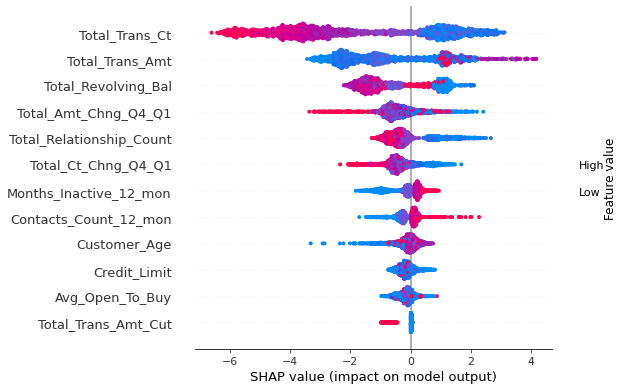

In [342]:
shap.initjs()
shap.summary_plot(shap_values, X_test)

* *Самый сильный признак: Total_Trans_Ct - общее количество транзакций*
* *Когда количество транзакций растет - снижается вероятность оттока*
* *При этом отток менее вероятен среди людей, у кого общий размер транзакций относительно небольшой*
* *Чем ниже общий оборотный баланс, тем выше вероятность оттока. Однако часть людей с очень высоким балансом более склонны к оттоку. Остальная  часть людей с высоким балансом зависит от другого признака (факторов) и попадает в неотток, этим можно объяснить разноцветное облако.*
* *Молодые люди менее склонны к оттоку, однако влияние возраста на данное решение не велико.*
* *Клиенты, не проявляющие активность бОльшее количетсво месяцев более склонны к оттоку*
* *Люди, с которыми количество контактов за 12 месяцев было выше склонны к оттоку: банк их утомил? :)*
* *Credit_Limit практически не влияет на целевую переменную (находится в облаке синих и красных объектов в области 0), образцы, имеющие невысокое значение тянут в отток. Но это касается лишь определенного сегмента клиентов (банк мог бы его изучить детальнее)*

In [354]:
shap.force_plot(explainer.expected_value, shap_values[5,:], X_test.iloc[5,:], link='logit', plot_cmap="DrDb")

In [344]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], link='logit', plot_cmap="DrDb")

In [345]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], link='logit', plot_cmap="DrDb")

In [346]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], link='logit', plot_cmap="DrDb")

In [347]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], link='logit', plot_cmap="DrDb")

In [352]:
idx = np.random.randint(len(X_test))
shap.force_plot(explainer.expected_value, shap_values[idx,:], X_test.iloc[idx,:], link='logit', plot_cmap="DrDb")

Выводы по общему графику в целом справедливы для отдельно взятых клиентов. Например, последний клиент имеет относительно небольшое количество транзакций, имеет всего один банковский продукт - отток

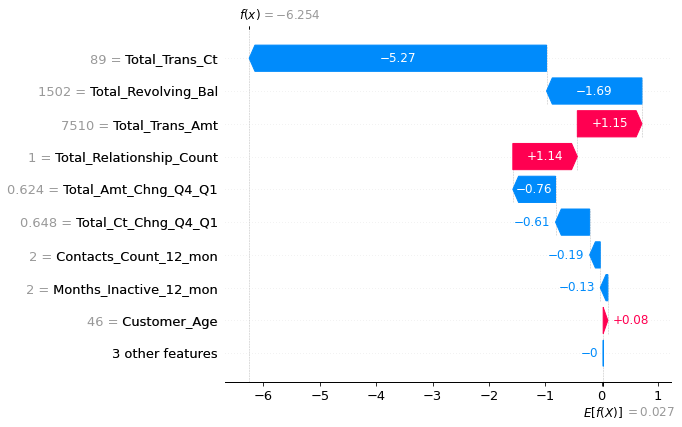

In [287]:
idx = 10
shap_values_one = explainer(X_test.iloc[idx:idx+1])
shap.plots.waterfall(shap_values_one[0])

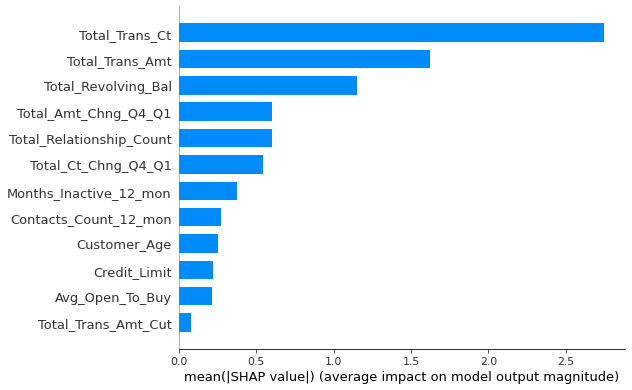

In [288]:
shap.summary_plot(shap_values, X_test, plot_type="bar")

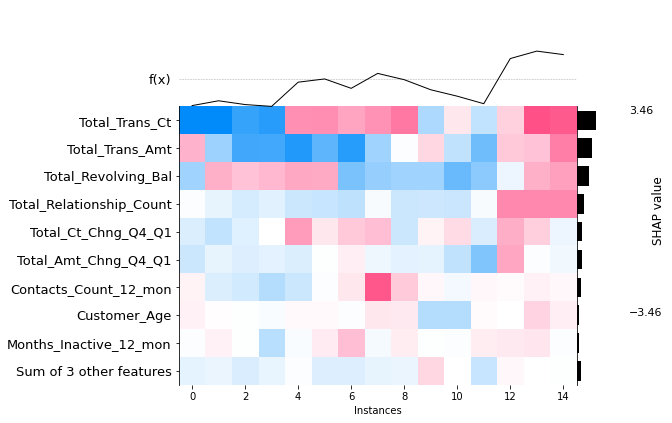

In [290]:
shap_values_ = explainer(X_test.sample(15))
shap.plots.heatmap(shap_values_)

In [291]:
shap.force_plot(explainer.expected_value, shap_values.values[0:5,:], X_test.iloc[0:5,:], plot_cmap="DrDb")

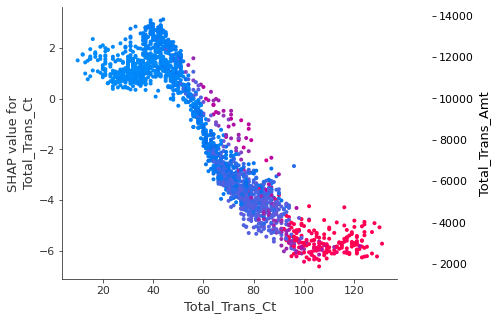

In [294]:
shap.dependence_plot("Total_Trans_Ct", shap_values, X_test, interaction_index="Total_Trans_Amt")

*Такая зависимость ожидалась, исходя из графиков выше*

In [244]:
import eli5

eli5.show_weights(xgbc, feature_names=X_train.columns.tolist())

Weight,Feature
0.2370,Total_Trans_Ct
0.1280,Total_Revolving_Bal
0.1280,Total_Relationship_Count
0.1161,Total_Trans_Amt_Cut
0.1134,Total_Trans_Amt
0.0610,Total_Ct_Chng_Q4_Q1
0.0475,Contacts_Count_12_mon
0.0450,Total_Amt_Chng_Q4_Q1
0.0380,Months_Inactive_12_mon
0.0337,Avg_Open_To_Buy


In [297]:
import lime.lime_tabular

explainer = lime.lime_tabular.LimeTabularExplainer(X_test.values, feature_names=X_test.columns.values.tolist(),
                                                   class_names=y_train.unique())

In [298]:
idx = np.random.randint(len(X_test))
exp = explainer.explain_instance(X_test.iloc[5].values, xgbc.predict_proba, num_features=6)
exp.show_in_notebook(show_all=False)